### This notebook trains an agent to solve the Unity Reacher environment. It uses the environment with one agent and also the environment with 20 agents. The code  is mainly from Udacity classroom and some parameters and code are modified to train the agent.

In [1]:
from unityagents import UnityEnvironment
import random
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline


BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-4 #1e-3  # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

#### Actor and critic models

In [2]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=400, fc2_units=300):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#### DDPG Agent, Noise and Replay Buffer

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    def __init__(self, state_size, action_size, num_agents, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random_seed
        
        # Actor Network (w/ Target Network)
        self.actor_local = Actor(self.state_size, self.action_size, self.seed).to(device)
        self.actor_target = Actor(self.state_size, self.action_size, self.seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        # Critic Network (w/ Target Network)
        self.critic_local = Critic(self.state_size, self.action_size, self.seed).to(device)
        self.critic_target = Critic(self.state_size, self.action_size, self.seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        # Noise process
        self.noise = OUNoise((num_agents,action_size), random_seed)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        for i in range(state.shape[0]):
            self.memory.add(state[i, :], action[i], reward[i], next_state[i, :], done[i])
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)        
        
    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()    
        return np.clip(action, -1, 1)        
        
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)    

### Run the environment

### This part uses environment with 1 agent. The previous 3 cells should run before this.

In [4]:
env = UnityEnvironment(file_name='Reacher.app')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size

states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


#### Train the agent using DDPG

In [6]:
num_agents = len(env_info.agents)
agents = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

def ddpg(n_episodes=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    
    average_scores_list = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
        
        while True:
            action = agents.act(state) 
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agents.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.format(i_episode, 
                                                                          np.mean(scores_deque),                                                                           np.mean(score)))
        average_score = np.mean(scores_deque)
        average_scores_list.append(average_score)
        
        if average_score > 30 or i_episode==n_episodes:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor_reacher.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic_reacher.pth') 
            if average_score > 30:
                break            
                
    return scores , average_scores_list

score , avg = ddpg()

Episode 1	Average Score: 0.19	Score: 0.190
Episode 2	Average Score: 0.27	Score: 0.360
Episode 3	Average Score: 0.53	Score: 1.040
Episode 4	Average Score: 0.68	Score: 1.120
Episode 5	Average Score: 0.58	Score: 0.170
Episode 6	Average Score: 0.57	Score: 0.550
Episode 7	Average Score: 0.60	Score: 0.740
Episode 8	Average Score: 0.61	Score: 0.680
Episode 9	Average Score: 0.65	Score: 1.030
Episode 10	Average Score: 0.76	Score: 1.750
Episode 11	Average Score: 0.85	Score: 1.750
Episode 12	Average Score: 0.98	Score: 2.380
Episode 13	Average Score: 0.90	Score: 0.000
Episode 14	Average Score: 1.07	Score: 3.230
Episode 15	Average Score: 1.02	Score: 0.320
Episode 16	Average Score: 1.00	Score: 0.640
Episode 17	Average Score: 1.03	Score: 1.600
Episode 18	Average Score: 1.14	Score: 3.020
Episode 19	Average Score: 1.15	Score: 1.290
Episode 20	Average Score: 1.15	Score: 1.230
Episode 21	Average Score: 1.19	Score: 1.990
Episode 22	Average Score: 1.20	Score: 1.380
Episode 23	Average Score: 1.17	Score: 0.3

Episode 182	Average Score: 26.10	Score: 34.720
Episode 183	Average Score: 26.20	Score: 24.960
Episode 184	Average Score: 26.28	Score: 27.760
Episode 185	Average Score: 26.49	Score: 33.230
Episode 186	Average Score: 26.61	Score: 30.780
Episode 187	Average Score: 26.73	Score: 28.370
Episode 188	Average Score: 26.93	Score: 30.220
Episode 189	Average Score: 26.99	Score: 30.840
Episode 190	Average Score: 27.14	Score: 32.860
Episode 191	Average Score: 27.31	Score: 30.410
Episode 192	Average Score: 27.48	Score: 35.150
Episode 193	Average Score: 27.58	Score: 31.160
Episode 194	Average Score: 27.76	Score: 32.170
Episode 195	Average Score: 27.94	Score: 30.340
Episode 196	Average Score: 28.06	Score: 32.240
Episode 197	Average Score: 28.19	Score: 30.230
Episode 198	Average Score: 28.23	Score: 27.610
Episode 199	Average Score: 28.30	Score: 28.920
Episode 200	Average Score: 28.49	Score: 35.600
Episode 201	Average Score: 28.59	Score: 29.870
Episode 202	Average Score: 28.73	Score: 32.910
Episode 203	A

#### Graph episode and average scores

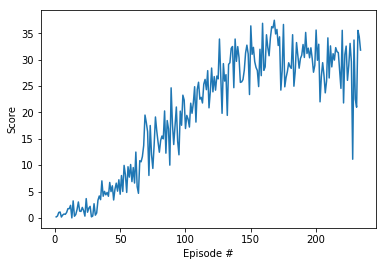

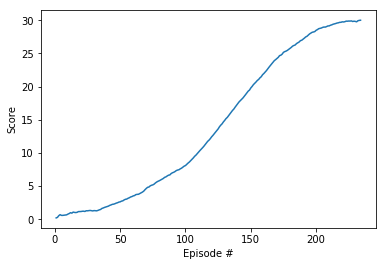

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score)+1), score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg)+1), avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Run the trained agent

In [6]:
agents.actor_local.load_state_dict(torch.load('checkpoint_actor_reacher.pth', map_location='cpu'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic_reacher.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
scores = np.zeros(num_agents)                          

while True:
    actions = agents.act(states, add_noise=False)                    
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    scores += rewards                         
    states = next_states                              
    if np.any(dones):                              
        break

In [9]:
env.close()

### This part uses environment with 20 agents. Before running this part, reset the kernel, run the first 3 cells an then continue from here.

In [4]:
env = UnityEnvironment(file_name='Reacher20.app')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size

states = env_info.vector_observations
state_size = states.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


#### Train the agent

In [6]:
num_agents = len(env_info.agents)
agents = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

def ddpg(n_episodes=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    
    average_scores_list = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
        
        while True:
            action = agents.act(state) 
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            agents.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}'.format(i_episode, 
                                                                          np.mean(scores_deque),                                                                           np.mean(score)))
        average_score = np.mean(scores_deque)
        average_scores_list.append(average_score)
        
        if average_score > 30 or i_episode==n_episodes:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor_reacher20.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic_reacher20.pth') 
            if average_score > 30:
                break            
                
    return scores , average_scores_list

score , avg = ddpg()

Episode 1	Average Score: 0.83	Score: 0.827
Episode 2	Average Score: 0.93	Score: 1.039
Episode 3	Average Score: 0.95	Score: 0.978
Episode 4	Average Score: 0.88	Score: 0.690
Episode 5	Average Score: 0.82	Score: 0.576
Episode 6	Average Score: 0.78	Score: 0.577
Episode 7	Average Score: 0.79	Score: 0.868
Episode 8	Average Score: 0.81	Score: 0.932
Episode 9	Average Score: 0.87	Score: 1.360
Episode 10	Average Score: 0.95	Score: 1.605
Episode 11	Average Score: 1.05	Score: 2.057
Episode 12	Average Score: 1.22	Score: 3.131
Episode 13	Average Score: 1.44	Score: 4.064
Episode 14	Average Score: 1.85	Score: 7.238
Episode 15	Average Score: 2.26	Score: 7.921
Episode 16	Average Score: 2.74	Score: 9.947
Episode 17	Average Score: 3.35	Score: 13.138
Episode 18	Average Score: 4.10	Score: 16.761
Episode 19	Average Score: 5.03	Score: 21.795
Episode 20	Average Score: 5.84	Score: 21.234
Episode 21	Average Score: 6.79	Score: 25.846
Episode 22	Average Score: 7.73	Score: 27.460
Episode 23	Average Score: 8.74	Scor

#### Graph episode and average scores

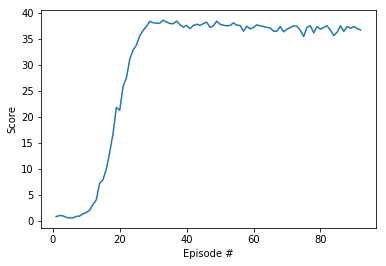

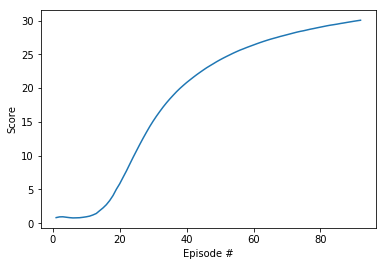

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(score)+1), score)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(avg)+1), avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### Run the trained agent

In [5]:
num_agents = len(env_info.agents)
agents = Agent(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=0)

agents.actor_local.load_state_dict(torch.load('checkpoint_actor_reacher20.pth', map_location='cpu'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic_reacher20.pth', map_location='cpu'))

env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
scores = np.zeros(num_agents)                          

while True:
    actions = agents.act(states, add_noise=False)                    
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    scores += rewards                         
    states = next_states                              
    if np.any(dones):                              
        break

In [6]:
env.close()